In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
import numpy as np
from hess.nets import Transformer

In [2]:
nx = 500
train_x = torch.linspace(0, 10, nx).unsqueeze(-1)
train_y = torch.sin(train_x * math.pi) + torch.sin(train_x)

In [3]:
optimus = Transformer(train_x, train_y, n_hidden=2, hidden_size=10,
                     activation=torch.nn.Tanh())

In [4]:
trained_pars = torch.load("../hess/saved-models/toy_regression.pt", map_location="cpu")

In [6]:
optimus.net.load_state_dict(trained_pars)

<All keys matched successfully>

In [7]:
hessian = torch.load("../hess/saved-models/toy_hessian.pt", map_location="cpu")

In [8]:
n_test = 1000
test_x = torch.linspace(0, 10, n_test).unsqueeze(-1)
test_y = torch.sin(test_x * math.pi) + torch.sin(test_x)

In [9]:
orig_pred = optimus(test_x)

In [10]:
e_val, e_vec = np.linalg.eig(hessian)
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

### Perturb in largest e-vec basis

In [11]:
import hess.utils as utils

In [12]:
top_vecs = e_vec[:, 0:3]

In [13]:
n_pert = 10
scale = 0.05
pert_preds = torch.zeros(n_test, n_pert)

In [14]:
for jj in range(10):
    wghts = torch.randn(3)*0.01
    perturb = top_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

tensor([[ 1.5739e-02,  1.2024e-02, -1.8723e-02, -1.3657e-02, -2.7563e-04,
          3.1631e-03,  1.0706e-02,  6.7108e-06,  9.8656e-03, -1.4416e-02,
          6.7006e-04,  1.6891e-04,  1.8169e-04, -7.0141e-04, -1.1680e-03,
          1.7052e-04,  5.9197e-04, -1.1804e-03,  5.9461e-04, -1.6971e-04,
          5.2497e-03,  2.8526e-03,  3.0765e-03, -5.2522e-03, -4.9326e-03,
          2.8973e-03,  5.2106e-03, -4.9294e-03,  5.2130e-03, -2.8779e-03,
          3.6660e-03,  1.5888e-03,  1.6830e-03, -3.7034e-03, -3.8384e-03,
          1.5991e-03,  3.5393e-03, -3.8356e-03,  3.5443e-03, -1.5936e-03,
         -3.5904e-04, -8.8708e-05, -9.5640e-05,  3.7418e-04,  5.8866e-04,
         -8.9582e-05, -3.1980e-04,  5.9967e-04, -3.2114e-04,  8.9142e-05,
          1.8921e-03,  2.6190e-03,  2.7421e-03, -1.7064e-03,  1.0199e-03,
          2.6370e-03,  2.3440e-03,  1.1479e-03,  2.3290e-03, -2.6283e-03,
          2.3349e-03,  5.9863e-04,  6.4280e-04, -2.4558e-03, -4.5506e-03,
          6.0440e-04,  2.0424e-03, -4.

### Perturb in smallest e-vec basis

In [15]:
bot_vecs = e_vec[:, -3:]

In [16]:
n_pert = 10
small_pert_preds = torch.zeros(n_test, n_pert)

In [17]:
for jj in range(10):
    wghts = torch.randn(3)
    perturb = bot_vecs.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)
    print(perturb.shape)
    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
    small_pert_preds[:, jj] = optimus(test_x).squeeze()
    
    optimus.net.load_state_dict(trained_pars)

torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])
torch.Size([1, 220])


### Plotting

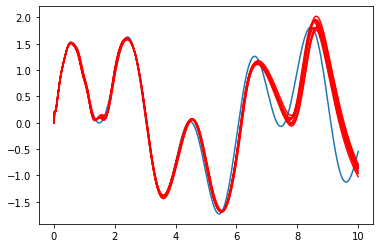

In [18]:
plt.plot(test_x, test_y.detach())
plt.plot(test_x, small_pert_preds.detach(), color="red")

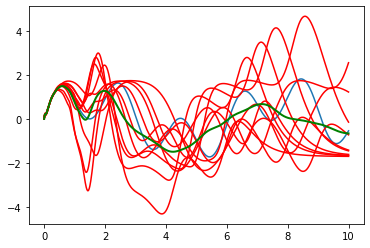

In [19]:
plt.plot(test_x, test_y.detach())
plt.plot(test_x, pert_preds.detach(), color="red")
plt.plot(test_x, pert_preds.mean(-1).detach(), color="green",
        linewidth=2.)

In [20]:
test = optimus(train_x)

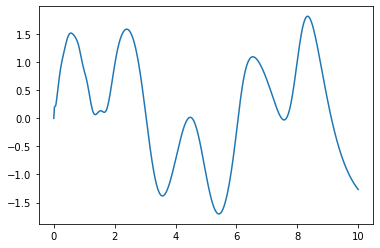

In [21]:
plt.plot(train_x, test.detach())

## Scratch

In [22]:
t1 = torch.randn(100, 1)
t2 = torch.randn(100, 1)

In [23]:
t1.squeeze().dot(t2.squeeze())

tensor(-17.7480)

In [24]:
t1.norm()

tensor(10.6153)

In [25]:
out = [p.data for p in optimus.net.parameters()]